In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(9,6)})

## 1. First we want to know how the monthly avegrage price varies.
The monthly data is obtained from calendar.csv

In [2]:
#read the dataset
calendar_df = pd.read_csv('./calendar.csv')

#find number of rows in dataset
rows_num = calendar_df.shape[0]

print('calendar.csv dataset contains %d rows.' % (rows_num))

calendar.csv dataset contains 2908660 rows.


In [3]:
#drop unrelated columns
calendar_df.drop(['adjusted_price', 'minimum_nights', 'maximum_nights'], axis=1, inplace=True)

#find the types of each column
calendar_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [4]:
#Slice the 'date' column into month and year column and change the 'price' from string to float type
calendar_df['date']=pd.to_datetime(calendar_df['date'])
calendar_df['month']=calendar_df.date.dt.month
calendar_df['year']=calendar_df.date.dt.year
calendar_df['price']=pd.to_numeric(calendar_df['price'].str.replace('[\$,]',''), errors='coerce')
calendar_df.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                float64
month                  int64
year                   int64
dtype: object

In [5]:
#find the basic information of price
min_price = calendar_df['price'].min()
max_price = calendar_df['price'].max()
mean_price = calendar_df['price'].mean()
median_price = calendar_df['price'].median()

print('The lowest price is %s and the highest price is %s.' % (min_price, max_price))
print('The average price is %s.' % (mean_price))
print('The median of price is %s.' % (median_price))

The lowest price is 10.0 and the highest price is 10000.0.
The average price is 160.63416521697278.
The median of price is 117.0.


In [6]:
calendar_df['price'].describe()

count    2.908660e+06
mean     1.606342e+02
std      2.525558e+02
min      1.000000e+01
25%      7.900000e+01
50%      1.170000e+02
75%      1.850000e+02
max      1.000000e+04
Name: price, dtype: float64

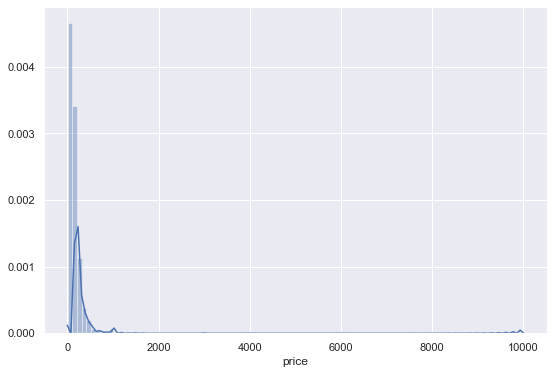

In [7]:
sns.distplot(calendar_df['price'], bins=100)

Text(0, 0.5, 'Price, $')

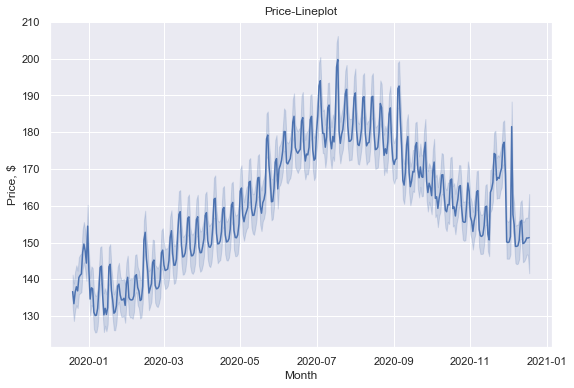

In [8]:
sns.lineplot(x='date', y='price', data=calendar_df)
plt.title('Price-Lineplot')
plt.xlabel('Month')
plt.ylabel('Price, $')

Text(5.960000000000001, 0.5, 'Price, $')

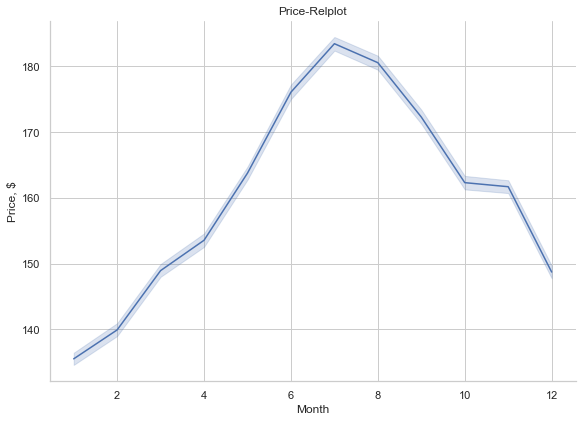

In [9]:
sns.set_style('whitegrid')
g = sns.relplot(x='month',y='price',kind='line',data=calendar_df)
g.fig.set_size_inches(9,6)
plt.title('Price-Relplot')
plt.xlabel('Month')
plt.ylabel('Price, $')

## 2. Then we want to know how the demand varies by time. 
The demand can not be get directly, so we made an assumption that the demand could be derived from the number of reviews.

In [10]:
#read the dataset
reviews_df = pd.read_csv('./reviews.csv')

#find number of rows in dataset
rows_num = reviews_df.shape[0]

print('reviews.csv dataset contains %d rows.' % (rows_num))

reviews.csv dataset contains 419901 rows.


In [11]:
#drop unrelated columns
reviews_df.drop(['reviewer_id', 'reviewer_id', 'reviewer_name', 'comments','listing_id'], axis=1, inplace=True)

#find the types of each column
reviews_df.dtypes

id       int64
date    object
dtype: object

In [12]:
#Slice the 'date' column into month and year column, same as how we deal with calendar.csv
reviews_df['date']=pd.to_datetime(reviews_df['date'])
reviews_df['month']=reviews_df.date.dt.month
reviews_df['year']=reviews_df.date.dt.year

reviews_df.dtypes

id                int64
date     datetime64[ns]
month             int64
year              int64
dtype: object

In [13]:
#find first and last date of the calendar
min_date = reviews_df['date'].min()
max_date = reviews_df['date'].max()
print('The first review happened on %s and the last one is on %s.' % (min_date, max_date))

The first review happened on 2008-09-15 00:00:00 and the last one is on 2019-12-19 00:00:00.


This reveals that the reviews.csv contains all reviews data sinice 2008. Since we are missing half month of the December review data, we decided to use 2018 reviews data ro reflect the demand.

In [14]:
reviews_2018=reviews_df[reviews_df['year'] == 2018]

Text(-6.289999999999999, 0.5, 'Reviews count')

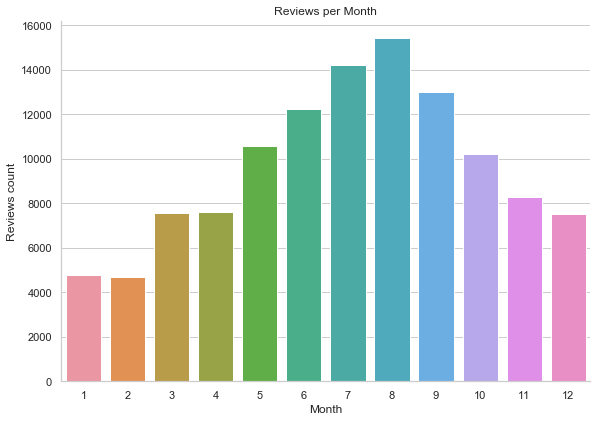

In [15]:
#reviews count per month from reveiws.csv
figure = sns.catplot(x="month", kind="count", data=reviews_2018)
figure.fig.set_size_inches(9,6)
plt.title('Reviews per Month')
plt.xlabel('Month')
plt.ylabel('Reviews count')

By comparing the monthly average price plot and the above monthly reviews count plot, we can easily find they have the same pattern and there should be some model lay under the data.
## 3. Linear Regression

In [27]:
calendar_df['date']=pd.to_datetime(calendar_df['date']).dt.strftime('%m-%d')
price_daily_averages = calendar_df.groupby(['date']).aggregate({'price':np.mean})
price_daily_averages.head()

,price
date,
01-01,142.280748
01-02,134.624247
01-03,137.691767
01-04,137.418926
01-05,131.049197


In [31]:
reviews_2018['date']=pd.to_datetime(reviews_2018['date']).dt.strftime('%m-%d')
reviews_daily_count= reviews_2018.groupby(['date']).agg('count')
reviews_daily_count.head()

,id,month,year
date,,,
01-01,487,487,487
01-02,251,251,251
01-03,151,151,151
01-04,105,105,105
01-05,112,112,112


In [33]:
daily = pd.merge(reviews_daily_count, price_daily_averages, on=['date'])
daily.head()

,id,month,year,price
date,,,,
01-01,487,487,487,142.280748
01-02,251,251,251,134.624247
01-03,151,151,151,137.691767
01-04,105,105,105,137.418926
01-05,112,112,112,131.049197


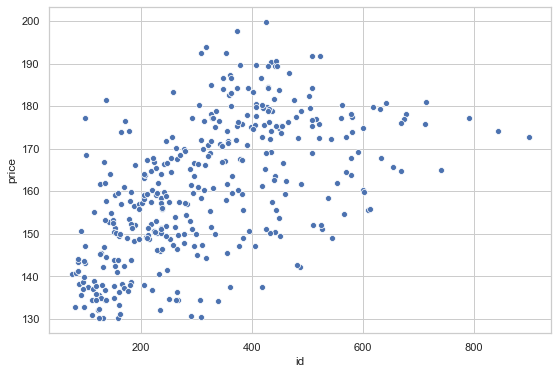

In [41]:
sns.scatterplot(x='id', y='price', data=daily)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, Y_train, Y_test = train_test_split(daily['id'],daily['price'], train_size = 0.7)

In [43]:
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

In [44]:
model = LinearRegression()
model.fit(X_train, Y_train)
a = model.intercept_
b = model.coef_
a = float(a)
b = float(b)
print('The linear regression equation of this model is y = {} + {} * x'.format(a, b))

The linear regression equation of this model is y = 140.9884057840407 + 0.062039616664135225 * x


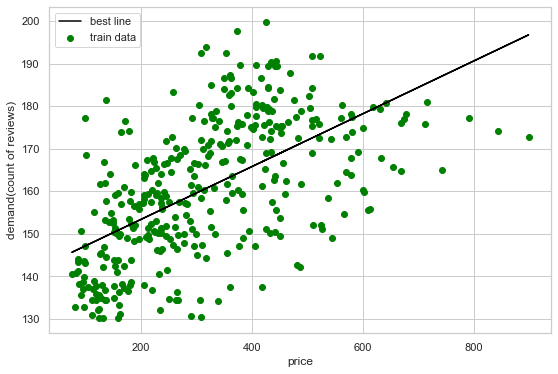

In [45]:
plt.scatter(daily['id'], daily['price'], color = 'green', label = 'train data')

plt.ylabel('demand(count of reviews)')
plt.xlabel('price')

Y_train_pred = model.predict(X_train)
plt.plot(X_train, Y_train_pred, color = 'black', label = 'best line')

plt.legend(loc = 2)
plt.show()

In [46]:
#R-squared value 
model.score(X_test, Y_test)

0.37130284214648923